## Imports

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
import pandas as pd
import numpy as np
import sys, os, time, datetime
import matplotlib.pyplot as plt


sys.path.append('libraries')
import signal_processing as spl 
import prediction_lib as pl
pl = reload(pl)
spl = reload(spl)

In [24]:
import IPython

In [25]:
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter
import urllib
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from tqdm import tqdm
import sys
from scipy import optimize
from IPython import display
from collections import Counter
from sklearn.externals import joblib

from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.cluster import KMeans
from hmmlearn.hmm import MultinomialHMM
from python_speech_features import mfcc

##  Load in Signal DF

In [26]:
load = True
name = 'NOISEY_LABELED_CHARACTER_INPUTS'
INPUT_FILE = 'data/LABELED_CHARACTER_INPUTS.csv' 
out_name = 'results/%s_RESULTS.csv' % name

In [27]:
if load and os.path.exists(out_name):
    RESULTS_DF = pd.read_csv(out_name, index_col = 0)
    RESULTS_DF.head()
else:
    RESULTS_DF = None

In [28]:
char_inps_raw = pd.read_csv(INPUT_FILE, index_col=0)
char_inps_raw['char'] = char_inps_raw['char'].fillna(' ').replace('#SPACE', ' ')
# char_inps_raw['peak_diff'] =char_inps_raw['peak_diff'].fillna(0)
char_inps_raw = char_inps_raw.fillna(0)
char_inps_raw.tail(10)

,index,peak time,signal,start time,end time,char,is_space,peak_diff,0,1,...,16791,16792,16793,16794,16795,16796,16797,16798,16799,16800
1042,1086,596.346667,12875.447266,596.311667,596.661667,b,0,0.270667,18.0,20.0,...,98.0,98.0,-60.0,-27.0,88.0,85.0,46.0,-21.0,-80.0,0.0
1043,1087,596.617333,22127.296875,596.582333,596.932333,b,0,0.149333,17.0,13.0,...,9.0,7.0,6.0,10.0,11.0,10.0,10.0,11.0,9.0,0.0
1044,1088,596.766667,2168.157959,596.731667,597.081667,i,0,0.354667,-5.0,4.0,...,-14.0,-16.0,-17.0,-13.0,-13.0,-21.0,-21.0,-14.0,-14.0,-19.0
1045,1089,597.121333,1214.426758,597.086333,597.436333,t,0,0.294000,26.0,26.0,...,48.0,243.0,253.0,147.0,56.0,-3.0,99.0,157.0,53.0,0.0
1046,1090,597.415333,25453.357422,597.380333,597.730333,,1,1.591333,10.0,6.0,...,-15.0,-15.0,-17.0,-25.0,-28.0,-21.0,-17.0,-21.0,-24.0,0.0
1047,1091,599.006667,6431.091797,598.971667,599.321667,h,0,0.247333,-3.0,-1.0,...,13.0,3.0,-6.0,17.0,10.0,-15.0,2.0,24.0,23.0,28.0
1048,1092,599.254000,3091.520508,599.219000,599.569000,o,0,0.462000,13.0,11.0,...,50.0,41.0,34.0,32.0,28.0,21.0,16.0,13.0,10.0,8.0
1049,1093,599.716000,913.455261,599.681000,600.031000,l,0,0.270667,2.0,4.0,...,40.0,-36.0,-24.0,100.0,-11.0,-66.0,54.0,46.0,41.0,33.0
1050,1094,599.986667,17315.521484,599.951667,600.301667,e,0,0.200667,-13.0,-19.0,...,-17.0,-140.0,-119.0,0.0,59.0,63.0,87.0,89.0,61.0,-7.0
1051,1095,600.187333,5176.197266,600.152333,600.502333,,0,0.000000,-18.0,-13.0,...,-12.0,-11.0,-7.0,-4.0,1.0,8.0,5.0,-1.0,2.0,6.0


In [29]:
targ_s = ''.join(char_inps_raw['char'].values)
targ_s

'alice was beginning to get very tired of sitting by her sister on the bank and having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind a well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her there was nothing so very emarkable in that nor did alice think it so very much oh dear i shall be late it occurred to her afterwards she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually toook a watch out of its packet and looked at it and then hurried on alice started to her feet and in another moment down went alice after it never once considering burning how in the 

In [43]:
PARAM_RESULTS ={}

In [44]:
STDEV = char_inps_raw[char_inps_raw.columns[8:]].values.std()

## Processing 

In [45]:
RATE = 44100
WHITEN = True
SAVE_THRESH= 0.45
TOL = 1e-2
NOISE = [1, .5, 1e-1, 1e-2, 1e-3]

should_loop = True


MAX_COLS = -1
MFCC_START = [0]
MFCC_END = [-60]
NUM_CLUSTERS = [50]
N_COMPONENTS = [None, 100]
DO_ALL = False


REPEATS = 24
SMOOTHS = map(lambda x : np.exp(x), range(1,2))

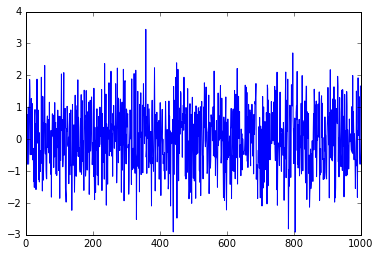

In [46]:
mean = 0
std = 1 
num_samples = 1000
samples = np.random.normal(mean, std, size=num_samples)

plt.plot(samples)
plt.show()

In [47]:
# actual = data[:,0]
# mean = 0
# std = np.std(actual) * 1e-1
# num_samples = len(actual)
# samples = np.random.normal(mean, std, size=num_samples)
# # plt.plot(actual + samples)
# wav.write("NOISEY.wav", RATE, (actual + samples))
# IPython.display.Audio('NOISEY.wav', autoplay=True)

In [ ]:
def build_params(smooth, end, start, cluster, comp, noise):
    _id = datetime.datetime.now()
    PARAM_RESULTS[_id] = {'RATE' : RATE,
        'TOL' : TOL,
        'INPUT_FILE' : INPUT_FILE,
         'MAX_COLS': MAX_COLS,
          'NUM_CLUSTERS' : cluster,
          'N_COMPONENTS' : comp,
          'MFCC_START' : start,
          'MFCC_END' : end,
          'WHITEN' : WHITEN,
          'DO_ALL' : DO_ALL,
          'SMOOTH' : smooth,
          'PREDICTION' : None,
          'ACCURACY_WO_SPACES' : None,
         'OVERALL_ACCURACY' : None,
         'SCORE' : None,
         'MODEL' : None,
        'MODEL_FNAME' : None,
            'NOISE' : noise
                          
         }
    return PARAM_RESULTS[_id], _id

def save(model = None, accuracy = None, _id = None):
    global RESULTS_DF
    if model:
        PARAM_RESULTS[_id]['MODEL_FNAME'] = "models/%s-%s.pkl" % (_id, accuracy)
        joblib.dump(model, "models/%s-%s.pkl" % (_id, accuracy))
        
    if RESULTS_DF is not None:
        RESULTS_DF = RESULTS_DF.append(pd.DataFrame(PARAM_RESULTS).T).drop_duplicates()
    else:
        RESULTS_DF = pd.DataFrame(PARAM_RESULTS).T
    
    
    
    
    RESULTS_DF.sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending=False).to_csv(out_name)
    
    by_smooth = RESULTS_DF[['ACCURACY_WO_SPACES','OVERALL_ACCURACY', 'SMOOTH']].dropna().astype(float).groupby('SMOOTH')
#     print 'max'
#     display.display(by_smooth.max().sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending =False).head(3))
#     print 'mean'
#     display.display(by_smooth.mean().sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending =False).head(3))
#     print 'var'
#     display.display(by_smooth.var().sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending =False).head(3))


def loop():
    
    # Copy and take subset
    char_inps = char_inps_raw[char_inps_raw.columns[:MAX_COLS]].copy()
    
    for _ in range(REPEATS):
        # Extract features
        for end in MFCC_END:
            for start in MFCC_START:
                for cluster in NUM_CLUSTERS:
                    for comp in N_COMPONENTS:
                        for nois in NOISE:
                            cepstrum_df = pl.extract_cepstrum(char_inps, RATE, mfcc_start=start, mfcc_end=end, noise = STDEV * nois)

                            # Cluster the sounds
                            cepstrum_df = pl.cluster(cepstrum_df, num_clusters = cluster, n_components = comp)

                            # Repeat the hmm experiement for each parameter

                            # For each smoothing parameter to be tested
                            for smooth in SMOOTHS:


                                estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
                                                                        cluster, t_smooth = smooth, tol = TOL,
                                                                        do_all = DO_ALL, verbose = False)  
                                print nois, smooth, acc, acc_wospace, score
                                params,_id = build_params(smooth, end, start, cluster, comp, nois)
                                params['OVERALL_ACCURACY'] = acc
                                params['ACCURACY_WO_SPACES'] = acc_wospace
                                params['PREDICTION'] = estimate
                                params['SCORE'] = score
                                params['MODEL'] = hmm

                                if acc > SAVE_THRESH:
                                    save(hmm, acc, _id)
                                else:
                                    save()
if should_loop:
    loop()

In [ ]:
RESULTS_DF = pd.DataFrame(PARAM_RESULTS).T
WORK_DF = RESULTS_DF[RESULTS_DF['DO_ALL'] == False].sort_values('SCORE')

In [ ]:
# Unique chars are a-z and space
unique_chars = np.array([' '] + map(lambda x : chr(x + ord('a')), range(26)))

# Number of unique
n_unique = len(unique_chars)

# Map char to id and vice versa
id_to_char = dict(zip(range(n_unique), unique_chars))
char_to_id = dict(zip(unique_chars, range(n_unique)))
results = pd.DataFrame(map(lambda x : np.squeeze(x), WORK_DF['PREDICTION'].map(lambda x : np.array(list(x))).values)).applymap(lambda x : char_to_id[x])
results.head()

In [ ]:
results.to_csv('LABLED_CHAR_INPUTS_COMBINED_RESULTS-51.7%.csv')
pl.accuracy(''.join(results.apply(lambda x : Counter(x).most_common(1)[0][0]).map(id_to_char).values), targ_s)

In [ ]:
save()

# Visualizing process 

In [ ]:
char_inps = char_inps_raw.copy()
char_inps = char_inps_raw[char_inps_raw.columns[:MAX_COLS]].copy()
char_inps.tail(10)

## Visualize Spaces 

In [ ]:
pl.view_char(char_inps, ' ', limit = 8, xlim = 600)

In [ ]:
pl.view_char(char_inps, 'e', limit = 8, xlim = 1000)

## Get the cepstrum features from the raw signal 

In [ ]:
 # Extract features
cepstrum_df = pl.extract_cepstrum(char_inps, RATE, mfcc_start=MFCC_START, mfcc_end=MFCC_END)

cepstrum_df.head()

In [ ]:
inds = cepstrum_df.dtypes == np.float64
data = cepstrum_df.ix[:,inds].values
# Standardize data
if WHITEN:
    data = whiten(data)
        
pca = PCA(n_components=N_COMPONENTS)
pca.fit(data)
data = pca.transform(data)
pca.explained_variance_ratio_.sum()

## Visualize Cepstrum Features 

In [ ]:
pl.view_char(cepstrum_df, ' ', xlim = 200, limit = 12)

In [ ]:
import sys
import wave
import math
import struct
import random
import argparse
from itertools import *

def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return izip_longest(fillvalue=fillvalue, *args)

def sine_wave(frequency=440.0, framerate=44100, amplitude=0.5):
    '''
    Generate a sine wave at a given frequency of infinite length.
    '''
    period = int(framerate / frequency)
    if amplitude > 1.0: amplitude = 1.0
    if amplitude < 0.0: amplitude = 0.0
    lookup_table = [float(amplitude) * math.sin(2.0*math.pi*float(frequency)*(float(i%period)/float(framerate))) for i in xrange(period)]
    return (lookup_table[i%period] for i in count(0))

def square_wave(frequency=440.0, framerate=44100, amplitude=0.5):
    for s in sine_wave(frequency, framerate, amplitude):
        if s > 0:
            yield amplitude
        elif s < 0:
            yield -amplitude
        else:
            yield 0.0

def damped_wave(frequency=440.0, framerate=44100, amplitude=0.5, length=44100):
    if amplitude > 1.0: amplitude = 1.0
    if amplitude < 0.0: amplitude = 0.0
    return (math.exp(-(float(i%length)/float(framerate))) * s for i, s in enumerate(sine_wave(frequency, framerate, amplitude)))

def white_noise(amplitude=0.9):
    '''
    Generate random samples.
    '''
    return (float(amplitude) * random.uniform(-1, 1) for i in count(0))

def compute_samples(channels, nsamples=None):
    '''
    create a generator which computes the samples.

    essentially it creates a sequence of the sum of each function in the channel
    at each sample in the file for each channel.
    '''
    return islice(izip(*(imap(sum, izip(*channel)) for channel in channels)), nsamples)

def write_wavefile(filename, samples, nframes=None, nchannels=2, sampwidth=2, framerate=44100, bufsize=2048):
    "Write samples to a wavefile."
    if nframes is None:
        nframes = -1

    w = wave.open(filename, 'w')
    w.setparams((nchannels, sampwidth, framerate, nframes, 'NONE', 'not compressed'))

    max_amplitude = float(int((2 ** (sampwidth * 8)) / 2) - 1)

    # split the samples into chunks (to reduce memory consumption and improve performance)
    for chunk in grouper(bufsize, samples):
        frames = ''.join(''.join(struct.pack('h', int(max_amplitude * sample)) for sample in channels) for channels in chunk if channels is not None)
        w.writeframesraw(frames)

    w.close()

    return filename

def write_pcm(f, samples, sampwidth=2, framerate=44100, bufsize=2048):
    "Write samples as raw PCM data."
    max_amplitude = float(int((2 ** (sampwidth * 8)) / 2) - 1)

    # split the samples into chunks (to reduce memory consumption and improve performance)
    for chunk in grouper(bufsize, samples):
        frames = ''.join(''.join(struct.pack('h', int(max_amplitude * sample)) for sample in channels) for channels in chunk if channels is not None)
        f.write(frames)

    f.close()

    return filename

    
    
frequency = 600.0
frequency2 = 2000.0
amplitude = 0.5
achannels = 1
bits = 16
etime= 6

# each channel is defined by infinite functions which are added to produce a sample.
# channels = ((sine_wave(frequency,RATE, amplitude),) for i in range(achannels))

# channels = ((sine_wave(frequency,RATE, amplitude),), (white_noise(amplitude=0.001),),
#                 (sine_wave(frequency2,RATE, amplitude),), (white_noise(amplitude=0.001),))

# channels = ((sine_wave(frequency,RATE, amplitude),), (white_noise(amplitude=0.1),),
#                 (sine_wave(frequency2,RATE, amplitude),), (white_noise(amplitude=0.2),))

channels = (( white_noise(amplitude=.1),) for i in range(achannels))

# convert the channel functions into waveforms
samples = compute_samples(channels, RATE * etime)

# write the samples to a file
filename = 'test.wav'

write_wavefile(filename, samples, RATE * etime, achannels, bits / 8, RATE)

IPython.display.Audio('test.wav', autoplay=True)

In [ ]:
pl.view_char(cepstrum_df, 'e', xlim = 200, limit = 12)

## Cluster the features

In [ ]:
# Cluster the sounds
cepstrum_df = pl.cluster(cepstrum_df, num_clusters = NUM_CLUSTERS, n_components = N_COMPONENTS)
cepstrum_df.head()

In [ ]:
pl.cluster_proportions(cepstrum_df, [' '] + map(lambda x : chr(x + ord('a')),  range(26)), num_clusters = NUM_CLUSTERS)

In [ ]:
cepstrum_df['Count'] = 1
scores = cepstrum_df[['char', 'cluster', 'Count']].groupby(['cluster', 'char']).count()
n = NUM_CLUSTERS 
fig, axes = plt.subplots((n-1)/4+1, 4, figsize=(24, n*3/2))

# Repeat for each coefficient
for cl in range(n):
    axe = axes[cl / 4][cl % 4]
   
    _ = scores.ix[cl].plot(kind='bar', ax = axe)
    _ = axe.set_title(cl)

## Build Transmission Matrix with bigrams

In [ ]:
pl = reload(pl)
A_df, n_unique, unique_chars, id_to_char, char_to_id  = pl.build_transmission_full()
A_df.head()

##  Check the proportion of spaces across the k means classes

In [ ]:
space_props= pl.get_props(cepstrum_df, NUM_CLUSTERS, ' ')
_  = space_props.plot(kind='bar', title = 'Space Proportions')

## Build emissions matrix

In [ ]:
Eta = pl.build_eta(cepstrum_df, unique_chars, NUM_CLUSTERS, do_all = DO_ALL)
Eta


## Get Unigram proportions

In [ ]:
char_counts = pl.get_char_counts(targ_s, unique_chars)
char_counts

## Run HMM

In [ ]:
Eta

In [ ]:
# smooth = 0.5
# estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
#                                                     NUM_CLUSTERS, t_smooth = smooth, tol = TOL,
#                                                     do_all = DO_ALL, verbose = True)  
# params,_id = build_params(smooth)
# params['OVERALL_ACCURACY'] = acc
# params['ACCURACY_WO_SPACES'] = acc_wospace
# params['PREDICTION'] = estimate
# params['SCORE'] = score
# params['MODEL'] = hmm

# if acc > SAVE_THRESH:
#     save(hmm, acc, _id)
# else:
#     save()

In [ ]:
# estimate

In [ ]:
targ_s

In [ ]:
# smooths = map(lambda x : np.exp(x), range(-10, 10))
# smooths = np.arange(0,2,.1)
for smooth in smooths:
    estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
                                                    NUM_CLUSTERS, t_smooth = smooth, tol = TOL,
                                                    do_all = DO_ALL, verbose = False)  
    params,_id = build_params(smooth)
    params['OVERALL_ACCURACY'] = acc
    params['ACCURACY_WO_SPACES'] = acc_wospace
    params['PREDICTION'] = estimate
    params['SCORE'] = score
    params['MODEL'] = hmm

    if acc > SAVE_THRESH:
        save(hmm, acc, _id)
    else:
        save()
    print smooth, acc, acc_wospace, score
    print estimate

In [ ]:
save()

In [ ]:
def scrapeone():
    webpage = 'https://www.gutenberg.org/files/11/11-h/11-h.htm'
    html = urllib.urlopen(webpage).read()
    soup = BeautifulSoup(html, 'html.parser')
    texts = soup.findAll(text=True)
    import re
    def visible(element):
        if element.parent.name in ['style', 'script', '[document]', 'head', 'title']:
            return False
        elif re.match('<!--.*-->', str(element.encode('utf-8'))):
            return False
        return True

    unique_chars = [' '] + map(lambda x : chr(x + ord('a')), range(26))

    raw_text = filter(lambda x : x in unique_chars, ' '.join(filter(visible, texts)).replace('\r\n', ' ').replace('\n', ' ').replace('\u2018', '').replace('\u2019', '').lower())
    raw_text = ' '.join(raw_text.split())

def scrape():
    results = {}
    raw_text_all = ''
    webpages = ['https://www.gutenberg.org/files/11/11-h/11-h.htm', 'https://www.gutenberg.org/files/1342/1342-h/1342-h.htm',
               'https://www.gutenberg.org/files/46/46-h/46-h.htm', 'https://www.gutenberg.org/files/84/84-h/84-h.htm',
               'https://www.gutenberg.org/files/76/76-h/76-h.htm', 'https://www.gutenberg.org/files/844/844-h/844-h.htm',
               'https://www.gutenberg.org/files/53638/53638-h/53638-h.htm', 'https://www.gutenberg.org/files/2542/2542-h/2542-h.htm',
               'https://www.gutenberg.org/files/1400/1400-h/1400-h.htm', 'https://www.gutenberg.org/files/98/98-h/98-h.htm',
               'https://www.gutenberg.org/files/74/74-h/74-h.htm', 'https://www.gutenberg.org/files/53641/53641-h/53641-h.html',
               'https://www.gutenberg.org/files/1232/1232-h/1232-h.htm', 'https://www.gutenberg.org/files/1661/1661-h/1661-h.htm',
               'https://www.gutenberg.org/files/345/345-h/345-h.htm', 'https://www.gutenberg.org/files/160/160-h/160-h.htm',
               'https://www.gutenberg.org/files/5200/5200-h/5200-h.htm', 'http://www.gutenberg.org/cache/epub/30254/pg30254.html',
               'https://www.gutenberg.org/files/1952/1952-h/1952-h.htm', 'https://www.gutenberg.org/files/2600/2600-h/2600-h.htm',
               'https://www.gutenberg.org/files/174/174-h/174-h.htm', 'https://www.gutenberg.org/files/2701/2701-h/2701-h.htm']
    for page in tqdm(webpages):
        html = urllib.urlopen(webpage).read()
        soup = BeautifulSoup(html, 'html.parser')
        texts = soup.findAll(text=True)
        import re
        def visible(element):
            if element.parent.name in ['style', 'script', '[document]', 'head', 'title']:
                return False
            elif re.match('<!--.*-->', str(element.encode('utf-8'))):
                return False
            return True

        unique_chars = [' '] + map(lambda x : chr(x + ord('a')), range(26))

        raw_text = filter(lambda x : x in unique_chars, ' '.join(filter(visible, texts)).replace('\r\n', ' ').replace('\n', ' ').replace('\u2018', '').replace('\u2019', '').lower())
        raw_text = ' '.join(raw_text.split())
        results[page] = raw_text
        raw_text_all += raw_text
        time.sleep(2)
# with open('data/guttenberg_text.txt', 'w') as f:
#     f.write(raw_text_all)